In [1]:
import pickle
import os

# 폴더 경로와 파일 이름을 별도로 선언
folder_path = 'aist_plusplus_final/keypoints3d'
file_name = 'gBR_sBM_cAll_d04_mBR1_ch01.pkl'
file_path = os.path.join(folder_path, file_name)

# pkl 파일 로딩
with open(file_path, 'rb') as file:
    pkl_data = pickle.load(file)


In [2]:
pkl_data['keypoints3d'].shape

(640, 17, 3)

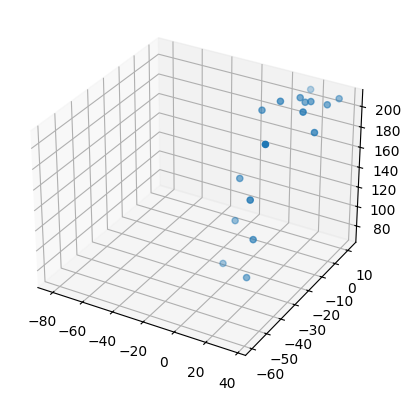

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation,PillowWriter

# 주어진 어레이
data = pkl_data['keypoints3d_optim']  # `keypoints3d_optim`, 'keypoints3d`

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 초기 설정
scat = ax.scatter(data[0, :, 0], data[0, :, 2], data[0, :, 1])

def update(frame):
    scat._offsets3d = (data[frame, :, 0], data[frame, :, 2], data[frame, :, 1])
    return scat,

ani = FuncAnimation(fig, update, frames=range(data.shape[0]), interval=50, blit=True)

# plt.show()
ani.save('animation.gif', writer=PillowWriter(fps=30))

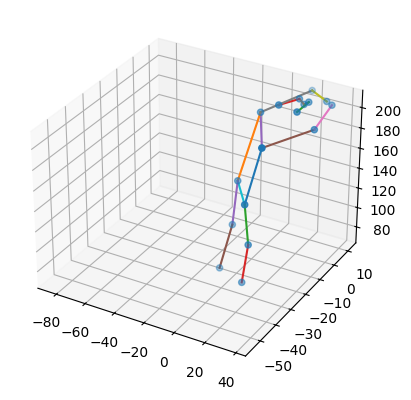

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

# 주어진 어레이
data = pkl_data['keypoints3d']  # `keypoints3d_optim`, 'keypoints3d`

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 초기 설정
scat = ax.scatter(data[0, :, 0], data[0, :, 2], data[0, :, 1])

# COCO 포맷의 키포인트 연결 정의
connections = [
    (0, 1), (0, 2), (1, 3), (2, 4),  # Head
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),  # Arms
    (11, 12), (5, 11), (6, 12),  # Torso
    (11, 13), (13, 15), (12, 14), (14, 16)  # Legs
]

lines = [ax.plot([data[0, c[0], 0], data[0, c[1], 0]],
                 [data[0, c[0], 2], data[0, c[1], 2]],
                 [data[0, c[0], 1], data[0, c[1], 1]])[0] for c in connections]

def update(frame):
    scat._offsets3d = (data[frame, :, 0], data[frame, :, 2], data[frame, :, 1])
    for line, (i, j) in zip(lines, connections):
        line.set_data([data[frame, i, 0], data[frame, j, 0]],
                      [data[frame, i, 2], data[frame, j, 2]])
        line.set_3d_properties([data[frame, i, 1], data[frame, j, 1]])
    return [scat] + lines

ani = FuncAnimation(fig, update, frames=range(data.shape[0]), interval=50, blit=True)

# plt.show()
ani.save('animation.gif', writer=PillowWriter(fps=30))

## rotation angle

In [3]:
import numpy as np
# 주어진 어레이
data = pkl_data['keypoints3d_optim']  # `keypoints3d_optim`, 'keypoints3d`

def calculate_angle(v1, v2):
    """두 벡터 간의 각도를 계산합니다."""
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return angle

def extract_angles(data):
    hip_angles = []
    shoulder_angles = []
    toe_angles = []
    
    for frame in range(data.shape[0]):
        left_hip = data[frame, 11]
        right_hip = data[frame, 12]
        left_shoulder = data[frame, 5]
        right_shoulder = data[frame, 6]
        left_toe = data[frame, 15]
        right_toe = data[frame, 16]
        
        hip_vector = right_hip - left_hip
        shoulder_vector = right_shoulder - left_shoulder
        toe_vector = right_toe - left_toe
        
        hip_angle = calculate_angle(hip_vector, [1, 0, 0])  # x축과의 각도
        shoulder_angle = calculate_angle(shoulder_vector, [1, 0, 0])  # x축과의 각도
        toe_angle = calculate_angle(toe_vector, [1, 0, 0])
        
        
        hip_angles.append(hip_angle)
        shoulder_angles.append(shoulder_angle)
        toe_angles.append(toe_angle)
    
    return hip_angles, shoulder_angles, toe_angles

hip_angles, shoulder_angles, to_angles = extract_angles(data)

In [ ]:

np.save('aist_angles/hip_angles.npy', hip_angles)
np.save('aist_angles/shoulder_angles.npy', shoulder_angles)
np.save('aist_angles/toe_angles.npy', to_angles)

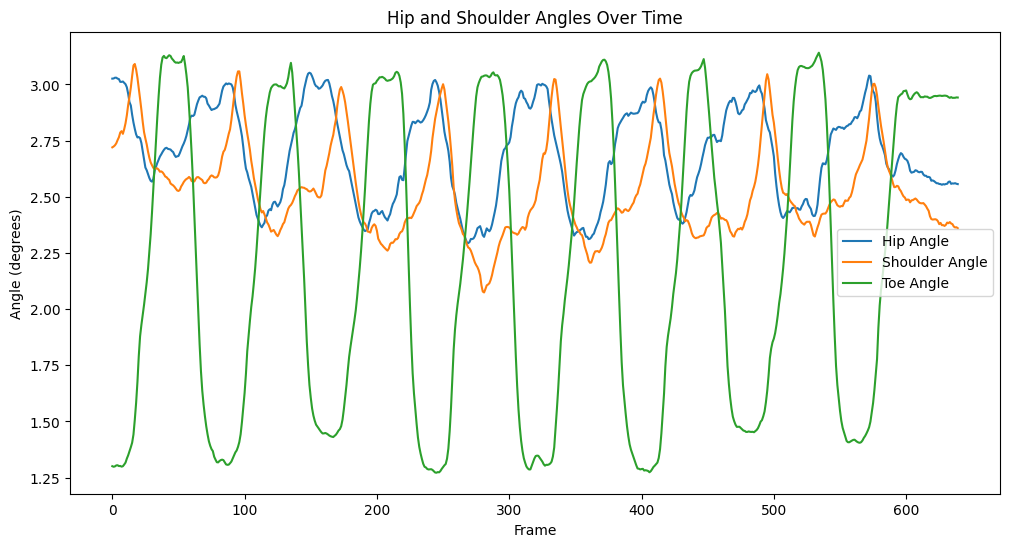

In [4]:
import matplotlib.pyplot as plt

# 결과를 그래프로 그리기
frames = range(len(hip_angles))

plt.figure(figsize=(12, 6))
plt.plot(frames, hip_angles, label='Hip Angle')
plt.plot(frames, shoulder_angles, label='Shoulder Angle')
plt.plot(frames, to_angles, label='Toe Angle')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Hip and Shoulder Angles Over Time')
plt.legend()
plt.show()

## body angle

In [9]:
import numpy as np
from itertools import combinations

def angle_with_xy_plane(points):
    """
    Calculate the angle between a plane formed by 4 points and the XY plane.
    
    Args:
        points (array-like): 4 points with 3D coordinates, shape (4, 3)
    
    Returns:
        float: Angle in radians between the plane and XY plane
    
    Raises:
        ValueError: If input is invalid
    """
    # Input validation
    points = np.array(points)
    if points.ndim != 2 or points.shape[0] != 4 or points.shape[1] != 3:
        raise ValueError("Input must be 4 points with 3D coordinates")
    
    # Check for coplanarity
    def is_coplanar(p1, p2, p3, p4):
        vectors = [p2 - p1, p3 - p1, p4 - p1]
        det = np.linalg.det(vectors)
        return np.isclose(det, 0, atol=1e-8)
    
    if is_coplanar(*points):
        raise ValueError("Points are coplanar, cannot determine plane orientation")

    normal_vectors = []
    for p1, p2, p3 in combinations(points, 3):
        v1 = p2 - p1
        v2 = p3 - p1
        normal_vector = np.cross(v1, v2)
        normal_vectors.append(normal_vector)

    # Average and normalize normal vector
    average_normal_vector = np.mean(normal_vectors, axis=0)
    average_normal_vector = average_normal_vector / np.linalg.norm(average_normal_vector)

    # Calculate angle with Z-axis
    z_axis = np.array([0, 0, 1])
    cos_theta = np.dot(average_normal_vector, z_axis)
    angle_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))

    return angle_rad

In [10]:
def extract_angles(data):
    lower_body_angles = []
    upper_body_angles = []
    lower_body_keys = [11, 12, 15, 16]
    upper_body_keys = [5, 6, 11,12]
    
    for frame in range(data.shape[0]):
        lower_body_vectors = [data[frame, key] for key in lower_body_keys]
        upper_body_vectors = [data[frame, key] for key in upper_body_keys]
        
        lower_body_angle_rad = angle_with_xy_plane(lower_body_vectors)
        lower_body_angles.append(lower_body_angle_rad)
        upper_body_angle_rad = angle_with_xy_plane(upper_body_vectors)
        upper_body_angles.append(upper_body_angle_rad)
    return lower_body_angles, upper_body_angles

In [ ]:
lower_body_angles, upper_body_angles = extract_angles(data)
np.save('aist_angles/lower_body_angles.npy', lower_body_angles)
np.save('aist_angles/upper_body_angles.npy', upper_body_angles)

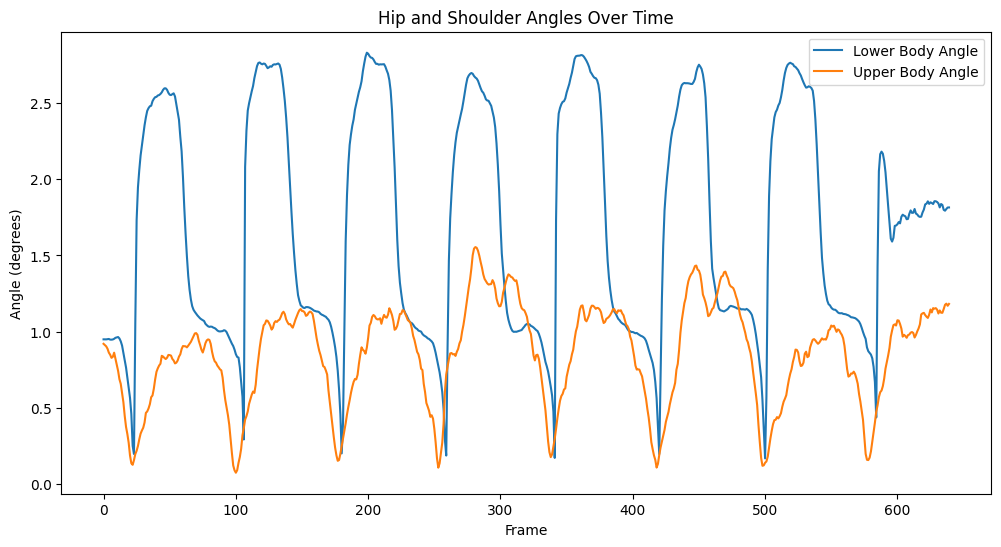

In [12]:
import matplotlib.pyplot as plt

# 결과를 그래프로 그리기
frames = range(len(lower_body_angles))

plt.figure(figsize=(12, 6))
plt.plot(frames, lower_body_angles, label='Lower Body Angle')
plt.plot(frames, upper_body_angles, label='Upper Body Angle')
# plt.plot(frames, to_angles, label='Toe Angle')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Hip and Shoulder Angles Over Time')
plt.legend()
plt.show()